```py
lfig = LiveFigure()
lfig.add_plot('train loss', trainloss, color='red', loc=(0,0))
lfig.add_plot('test loss', testloss, color='green', loc=(0,0))
lfig.add_plot('train acc', trainacc, color='blue', loc=(0,1))
lfig.add_plot('test acc', testacc, color='orange', loc=(0,1))
lfig.add_moving_img('preds', [], row=1)
lfig.draw(redraw=False)
lfig.update('train loss', trainloss)
...
```

In [62]:
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'

from typing import Any, Optional
import math

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.artist import Artist
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
from matplotlib.image import AxesImage
from matplotlib.ticker import AutoMinorLocator, MaxNLocator, AutoLocator

import torch
import numpy as np

from IPython import display

def norm_torange(x, range=(0, 1)):
    x -= x.min()
    if x.max()!=0:
        x /= x.max()
    else: return x
    x *= (range[1] - range[0])
    x += range[0]
    return x

def _prepare_linechart_data(data):
    if isinstance(data, dict):
        if "x" in data: return data["x"], data["y"]
        else: return list(data.keys()), list(data.values())

    if data is None: return [], []
    if isinstance(data, torch.Tensor): data = data.detach().cpu().numpy()
    elif not isinstance(data, np.ndarray): data = np.asanyarray(data)

    if data.ndim == 0:
        return [], []

    elif data.ndim == 1:
        x = list(range(len(data)))
        y = data

    elif data.ndim == 2:
        if data.shape[0] == 2:
            x,y = data
        else: x, y = data.T

    else: raise ValueError(f"Invalid shape {data.shape}, data must be 1D or 2D")

    return x,y

def _prepare_image_data(x, mode='auto', allow_alpha=False):
    # convert to numpy
    if isinstance(x, torch.Tensor): x = x.detach().cpu().numpy()
    elif not isinstance(x, np.ndarray): x = np.array(x)

    # determine mode
    if mode == "auto":
        if x.ndim > 3: mode = "*c*"
        if x.ndim == 3 and x.shape[2] > 4 and x.shape[0] < x.shape[2]: mode = 'c*'

    # if batched, take central element
    if mode == "*c*":
        while x.ndim > 3: x = x[int(x.shape[-1]//2)]
        mode = "c*"

    # if channel first, transpose
    if mode == "c*":
        x = x.transpose(1,2,0)

    # fix invalid ch count
    if x.ndim == 3:
        if x.shape[2] == 2:
            x = np.concatenate([x, x[:, :, 0:1]], axis=2)
        elif x.shape[2] > (4 if allow_alpha else 3):
            x = x[:,:,:3]

    return x

def _prepare_scatter_data(data):
    if isinstance(data, dict):
        if "x" in data: return data
        else: return {"x":list(data.keys()), "y":list(data.values()), "c":None, "s":None}
    if data is None: return {"x":[], "y":[], "c":None, "s":None}
    if isinstance(data, torch.Tensor): data = data.detach().cpu().numpy()
    elif not isinstance(data, np.ndarray): data = np.asanyarray(data)

    if data.ndim == 0: return {"x":[], "y":[], "c":None, "s":None}
    if data.ndim == 1: return {"x":list(range(len(data))), "y":data, "c":None, "s":None}
    if data.ndim == 2:
        if data.shape[1] == 1: return {"x":list(range(data.shape[0])), "y":data[0], "c":None, "s":None}
        if data.shape[1] == 2: return {"x":data[:,0], "y":data[:,1], "c":None, "s":None}
        if data.shape[1] == 3: return {"x":data[:,0], "y":data[:,1], "c":norm_torange(data[:,2], (0,1)), "s":None}
        if data.shape[1] == 4: return {"x":data[:,0], "y":data[:,1], "c":norm_torange(data[:,2], (0,1)), "s":norm_torange(data[:,3], (0,15))}
        elif data.shape[1] <= 4: return _prepare_scatter_data(data.T)
        else: raise ValueError(f"Invalid scatter shape {data.shape}")
    else: raise ValueError(f"Invalid scatter shape {data.shape}")

def _match_target(artists:list[Artist], target:Any, types = (Line2D,PathCollection,AxesImage)) -> list[Any]:
    artists = [a for a in artists if isinstance(a,types)]
    if target is None: return artists
    if isinstance(target, int): return [artists[target]]
    if isinstance(target, str): return [a for a in artists if a.get_label() == target]
    if isinstance(target, (list, tuple)): return [a for a in artists if a.get_label() in target]
    if isinstance(target, slice): return artists[target]
    if callable(target): return [a for a in artists if target(a)]
    raise ValueError(f"invalid target type {type(target)}")

def _dict_update(d:dict, **kwargs):
    for k,v in kwargs.items():
        if v is not None:
            d[k] = v
    return d

def _ax_settings(ax:Axes, kwargs):
    prop = {"size":6}

    leg = ax.legend(prop=prop, edgecolor=None)
    leg.get_frame().set_alpha(0.3)

    if "xlim" in kwargs: ax.set_xlim(*kwargs["xlim"])
    if "ylim" in kwargs: ax.set_ylim(*kwargs["ylim"])

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator('auto')) # type:ignore
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator('auto')) # type:ignore

    ax.grid(which="major", color='black', alpha=0.08)
    ax.grid(which="minor", color='black', alpha=0.03)

    if "xlabel" in kwargs: ax.set_xlabel(kwargs["xlabel"])
    if "ylabel" in kwargs: ax.set_ylabel(kwargs["ylabel"])
    if "title" in kwargs: ax.set_title(kwargs["title"])
    return ax

def axplot(ax:Axes, data, label, **kwargs):
    x, y = _prepare_linechart_data(data)
    plot_kwargs = {k:v for k,v in kwargs.items() if k not in ["xlim", "ylim", "xlabel", "ylabel", "title"]}
    ax.plot(x,y, label=label, **plot_kwargs)
    _ax_settings(ax, kwargs)

def axplot_update(ax:Axes, data, label, **kwargs):
    x, y = _prepare_linechart_data(data)
    if ax.lines:
        artists:list[Line2D] = _match_target(ax.get_children(), label, Line2D)
        if len(artists) > 1: raise ValueError(f"Found multiple artisis with {label} for some reason, {[i.get_label() for i in artists]}")
        if len(artists) == 0: raise ValueError(f"No artists with {label} found, there are {[i.get_label() for i in artists]}")
        for l in artists:
            l.set_xdata(x) # type:ignore
            l.set_ydata(y) # type:ignore

    # recompute the ax.dataLim
    ax.relim()
    if "xlim" in kwargs: ax.set_xlim(*kwargs["xlim"])
    if "ylim" in kwargs: ax.set_ylim(*kwargs["ylim"])
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()

def aximshow(ax:Axes, data, label, **kwargs):
    img = _prepare_image_data(data, kwargs["mode"], kwargs["allow_alpha"])
    plot_kwargs = {k:v for k,v in kwargs.items() if k not in ["allow_alpha", "mode", "xlabel", "ylabel", "title"]}
    ax.imshow(img, label=label, **plot_kwargs)
    if "xlabel" in kwargs: ax.set_xlabel(kwargs["xlabel"])
    if "ylabel" in kwargs: ax.set_ylabel(kwargs["ylabel"])
    if "title" in kwargs: ax.set_title(kwargs["title"])

def aximshow_update(ax:Axes, data, label, **kwargs):
    img = _prepare_image_data(data, kwargs["mode"], kwargs["allow_alpha"])
    artists:list[AxesImage]  = _match_target(ax.get_children(), label, AxesImage)
    if len(artists) > 1: raise ValueError(f"Found multiple artisis with {label} for some reason, {[i.get_label() for i in artists]}")
    if len(artists) == 0: raise ValueError(f"No artists with {label} found, there are {[i.get_label() for i in artists]}")
    for l in artists:
        l.set_data(img) # type:ignore
        l.set_norm(None) # type:ignore

def axscatter(ax:Axes, data, label, **kwargs):
    d = _prepare_scatter_data(data)
    x, y, c, s = d["x"], d["y"], d["c"], d["s"]
    plot_kwargs = {k:v for k,v in kwargs.items() if k not in ["xlim", "ylim", "xlabel", "ylabel", "title"]}
    ax.scatter(x, y, s=s, c=c, label=label, **plot_kwargs) # type:ignore
    _ax_settings(ax, kwargs)

def axscatter_update(ax:Axes, data, label, **kwargs):
    d = _prepare_scatter_data(data)
    x, y, c, s = d["x"], d["y"], d["c"], d["s"]
    artists:list[PathCollection]   = _match_target(ax.get_children(), label, PathCollection)
    if len(artists) > 1: raise ValueError(f"Found multiple artisis with {label} for some reason, {[i.get_label() for i in artists]}")
    if len(artists) == 0: raise ValueError(f"No artists with {label} found, there are {[i.get_label() for i in artists]}")
    for l in artists:
        l.set_offsets(np.stack([x, y]).T) # type:ignore
        if s is not None: l.set_sizes(s) # type:ignore
        if c is not None: l.set_array(c) # type:ignore
        #l.set_color(c)
        l.set_norm(None) # type:ignore
    # recompute the ax.dataLim
    ax.relim()
    if "xlim" in kwargs: ax.set_xlim(*kwargs["xlim"])
    if "ylim" in kwargs: ax.set_ylim(*kwargs["ylim"])
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()

def axpath(ax:Axes, data, label, **kwargs):
    d = _prepare_scatter_data(data)
    axplot(ax, d, label, **kwargs)
    axscatter(ax, d, label, **kwargs)

def axpath_update(ax:Axes, data, label, **kwargs):
    d = _prepare_scatter_data(data)
    axplot_update(ax, d, label, **kwargs)
    axscatter_update(ax, d, label, **kwargs)

class LiveFigure:
    def __init__(self):
        self.loc_label: dict[tuple[int,int], list[Any]] = {}
        self.label_data: dict[Any,dict [str, Any]] = {}
        self.label_ax: dict[Any, Axes] = {}
        self.needs_init = set()
        self.fig = None
        self.ax = None

    def _add_loc(self, loc, label):
        if loc not in self.loc_label:
            self.loc_label[loc] = [label]
        else: self.loc_label[loc].append(label)
        self.needs_init.add(label)

    def add_plot(self, label, loc, linewidth=1, xlim=None,ylim=None,xlabel=None,ylabel=None,title=None, **kwargs):
        kwargs = _dict_update(kwargs, linewidth=linewidth,xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel,title=title)
        self.label_data[label] = {"draw func":axplot, "update func": axplot_update, "label":label, "kwargs": kwargs}
        self._add_loc(loc, label)

    def add_image(self, label, loc, cmap='gray', vmin=None,vmax=None,alpha=None,xlabel=None,ylabel=None,title=None, allow_alpha=False,mode="auto",**kwargs):
        kwargs = _dict_update(kwargs,cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha, xlabel=xlabel, ylabel=ylabel,title=title,allow_alpha=allow_alpha,mode=mode)
        self.label_data[label] = {"draw func":aximshow, "update func": aximshow_update, "label":label,  "kwargs": kwargs}
        self._add_loc(loc, label)

    def add_scatter(self, label, loc, alpha = 0.5,cmap='gnuplot2', xlim=None,ylim=None,xlabel=None,ylabel=None,title=None, **kwargs):
        kwargs = _dict_update(kwargs, alpha=alpha,xlim=xlim,cmap=cmap, ylim=ylim, xlabel=xlabel, ylabel=ylabel,title=title)
        self.label_data[label] = {"draw func":axscatter, "update func": axplot_update, "label":label,  "kwargs": kwargs}
        self._add_loc(loc, label)

    def add_path(self, label, loc, linewidth=1, xlim=None,ylim=None,xlabel=None,ylabel=None,title=None, **kwargs):
        kwargs = _dict_update(kwargs, linewidth=linewidth,xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel,title=title)
        self.label_data[label] = {"draw func":axpath, "update func": axpath_update, "label":label,"kwargs": kwargs}
        self._add_loc(loc, label)


    def draw(self, auto_redraw=True, force_redraw = False, figsize = None, layout="compressed", **kwargs):
        # create figure for the first time
        if force_redraw or (auto_redraw and self.fig is None):

            # make sure ncols nrows are not lower than sizes
            sizes = list(self.loc_label.keys())
            colmax = max([i[0] for i in sizes])
            rowmax = max([i[1] for i in sizes])
            nrow = rowmax + 1
            ncol = colmax + 1

            if isinstance(figsize, int): figsize = (nrow*figsize, ncol*figsize) # type:ignore

            # create figure and display
            self.fig, self.ax = plt.subplots(nrow, ncol, figsize=figsize, layout=layout, **kwargs) # type:ignore
            if not isinstance(self.ax, np.ndarray): self.ax = np.array([self.ax])
            self.display = display.display("", display_id=True)

            # fill in empty places
            for col in range(ncol):
                for row in range(nrow):
                    if (col, row) not in self.loc_label:
                        self.loc_label[(row, col)] = []

            # sort locations
            self.sorted_data = [v for k,v in sorted(self.loc_label.items(), key=lambda x: x[0])]

            # plot
            for i,ax in enumerate(self.ax.ravel()):
                if i<len(self.sorted_data):
                    labels = self.sorted_data[i]
                    if len(labels) > 0:
                        for label in labels:
                            #data = self.label_data[label]
                            #data["draw func"](ax, data["data"], label=label, **data["kwargs"])
                            self.label_ax[label] = ax
                    else:
                        ax.set_axis_off()
                        ax.set_frame_on(False)
                else:
                    ax.set_axis_off()
                    ax.set_frame_on(False)

            # self.draw() # this causes it to do stuff twice which may or may not fix not drawing bug, Dont Work

        self.display.update(self.fig) # type:ignore

    def update(self, label, data, draw=False):
        if label in self.needs_init:
            self.label_data[label]["draw func"](self.label_ax[label], data, label, **self.label_data[label]["kwargs"])
            self.needs_init.remove(label)
        self.label_data[label]["update func"](self.label_ax[label], data, label, **self.label_data[label]["kwargs"])
        if draw: self.display.update(self.fig) # type:ignore

    def update_from_dict(self, d, draw=False):
        for label, data in d.items():
            self.update(self.label_ax[label], data, draw)

    def close(self): plt.close(self.fig)
    def __enter__(self):
        return self
    def __exit__(self,exc_type, exc_val, exc_tb):
        self.close()



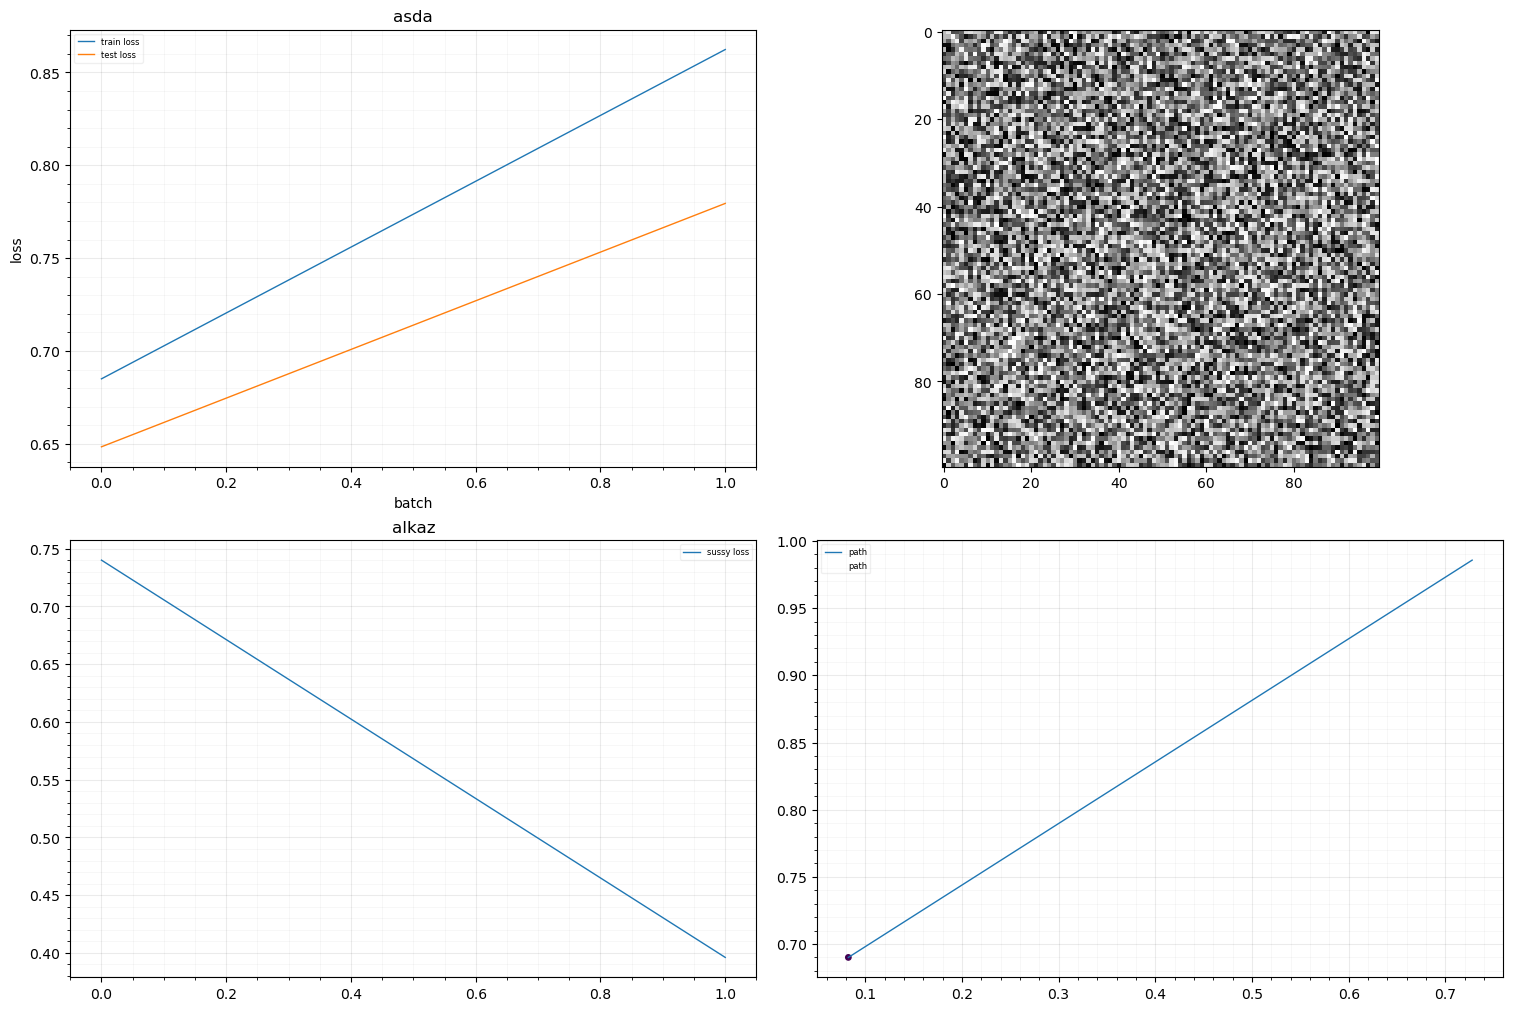

KeyboardInterrupt: 

In [63]:
import random
import time
trainloss = []
testloss = []
whatever = []
stuff = []
with LiveFigure() as lfig:
    lfig.add_plot("train loss", (0,0), xlabel='batch', ylabel='loss', linewidth=1, title='oasihd')
    lfig.add_plot("test loss", (0,0), linewidth=1,title='asda')
    lfig.add_plot("sussy loss", (1,0),title='alkaz')
    lfig.add_image("image", (0,1))
    lfig.add_path("path", (1,1))

    lfig.draw(figsize = (20,10))
    for _ in range(100):
        trainloss.append(random.random())
        testloss.append(random.random())
        whatever.append(random.random())
        stuff.append([random.random(),random.random(),random.random(),random.random()])
        #lfig.ax.ravel()[0].plot(trainloss)
        lfig.update("train loss", trainloss)
        lfig.update("test loss", testloss)
        lfig.update("sussy loss", whatever)
        lfig.update("image", np.random.uniform(random.random(), 1+random.random(), size = (100, 100)))
        lfig.update("path", stuff)
        lfig.draw()